In [1]:
# For some graphs, the following packages are required:

# !pip install --upgrade pip setuptools wheel
# !pip install 'critdd @ git+https://github.com/mirkobunse/critdd'

# Before installing the jupyter_tikz extension, you need to install some pre-requisites:
# https://jupyter-tikz.readthedocs.io/stable/installation/
# !pip install jupyter-tikz

In [2]:
import numpy as np
import pandas as pd
from aggregated_results_utils import (
    get_cd_diagram_for_dataset,
    get_hparams_comparison_table_for_dataset,
    get_top10_test_val_table_for_dataset,
    plot_random_time_series,
)

In [3]:
%load_ext jupyter_tikz

In [4]:
# For CD diagrams, we need to set the preamble to include the pgfplots package.
preamble = """
\\usepackage{pgfplots}
\\pgfplotsset{compat=1.18}
"""

## Download cleaned data

__You can get it after running `run_exp.py`, `get_results.py` and `clean_results.ipynb` sripts.__

In [5]:
res_df = pd.read_csv("../results/agg_results__normalized_True_cleaned.csv")
res_df = res_df.fillna("None")

# Rename some objects for better readability
res_df["strategy_time"] = res_df["strategy_time"].replace(
    {
        "FlatWideMIMOStrategy__model_horizon_NaN": "FlatWideMIMO",
        "RecursiveStrategy__model_horizon_6.0": "Recursive (MH = 6)",
        "RecursiveStrategy__model_horizon_1.0": "Recursive (MH = 1)",
        "MIMOStrategy__model_horizon_NaN": "MIMO",
    }
)
res_df["datetime"] = res_df["datetime"].replace(
    {
        "with_normalization_over_all": "True",
        "False": "False",
    }
)
res_df["id"] = res_df["id"].replace(
    {
        "with_le_normalization_over_all": "True",
        "False": "False",
    }
)
res_df["transformer_name"] = res_df["transformer_name"].replace(
    {
        "LastKnownNormalizer": "StandardScaler + LastKnownNormalizer",
        "DifferenceNormalizer": "StandardScaler + DifferenceNormalizer",
        "None": "StandardScaler",
        "LastKnownNormalizer_wo_standardscaler": "LastKnownNormalizer (wo. Scaler)",
        "DifferenceNormalizer_wo_standardscaler": "Difference (wo. Scaler)",
    }
)

In [6]:
res_df

,dataset,model,strategy_time,datetime,id,transformer_name,transformer_regime,mae_test,rmse_test,fit_time_test,forecast_time_test,mae_val,rmse_val,fit_time_val,forecast_time_val,mode
0,ILI,GPT4TS_NN,FlatWideMIMO,True,False,StandardScaler + LastKnownNormalizer,delta,1.243883,1.706754,502.091050,12.864784,0.569074,0.752735,502.091050,6.166278,multivariate CI
1,ILI,GPT4TS_NN,FlatWideMIMO,True,False,StandardScaler + DifferenceNormalizer,delta,1.701872,2.270460,1497.298979,13.178518,0.711456,0.899204,1497.298979,6.888815,multivariate CI
2,ILI,GPT4TS_NN,FlatWideMIMO,True,False,StandardScaler + LastKnownNormalizer,delta,1.478281,2.015969,494.907681,10.233515,0.592290,0.779328,494.907681,5.229473,multivariate CM
3,ILI,GPT4TS_NN,FlatWideMIMO,True,False,StandardScaler + DifferenceNormalizer,delta,1.538565,2.058272,749.656191,10.083811,0.675936,0.868844,749.656191,5.270533,multivariate CM
4,ILI,GPT4TS_NN,Recursive (MH = 6),False,False,StandardScaler + DifferenceNormalizer,delta,1.368265,1.910145,24.581788,8.618566,0.624708,0.815894,24.581788,6.636307,multivariate CM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1854,nn5,GPT4TS_NN,Recursive (MH = 6),False,False,StandardScaler + DifferenceNormalizer,delta,0.684631,0.958885,453.588251,51.265314,0.604655,0.843581,453.588251,22.873922,global
1855,nn5,GPT4TS_NN,Recursive (MH = 6),False,True,StandardScaler + DifferenceNormalizer,delta,0.677569,0.953565,605.040276,57.737805,0.592177,0.833624,605.040276,25.924835,global
1856,nn5,GPT4TS_NN,FlatWideMIMO,True,False,StandardScaler,None,0.976345,1.197459,483.842842,33.433428,0.953767,1.167051,483.842842,13.496710,multivariate CM
1857,nn5,GPT4TS_NN,FlatWideMIMO,True,False,StandardScaler + LastKnownNormalizer,delta,1.135932,1.432081,604.132692,39.004640,1.194786,1.532248,604.132692,17.368336,multivariate CM


In [37]:
current_df = res_df.copy()

# Some experiments on pyboost were run in the setting "wo_standardscaler" and with "ratio" regime,
# and we want to save it independently.
current_df = current_df[
    ~(
        (current_df["transformer_regime"] == "ratio")
        | (
            current_df["transformer_name"].isin(
                ["LastKnownNormalizer (wo. Scaler)", "Difference (wo. Scaler)"]
            )
        )
    )
]
# We save boosting results without the "wo_standardscaler" regime for later analysis.
current_df_wo_standardscaler = res_df[
    (
        res_df["transformer_name"].isin(
            ["LastKnownNormalizer (wo. Scaler)", "Difference (wo. Scaler)"]
        )
    )
]

## Dataset 1: ILI (national_illness)

In [48]:
df = pd.read_csv("../../../datasets/global/ILI.csv")
df["date"] = pd.to_datetime(df["date"])
df.head()

critical_difference_code = get_cd_diagram_for_dataset(current_df, dataset="ILI", save_latex=True)
hparams_comparison_table = get_hparams_comparison_table_for_dataset(current_df, dataset="ILI", save_latex=True)
top10_table = get_top10_test_val_table_for_dataset(pd.concat([current_df, current_df_wo_standardscaler]), dataset="ILI", save_latex=True)

### Plot random 5 time series

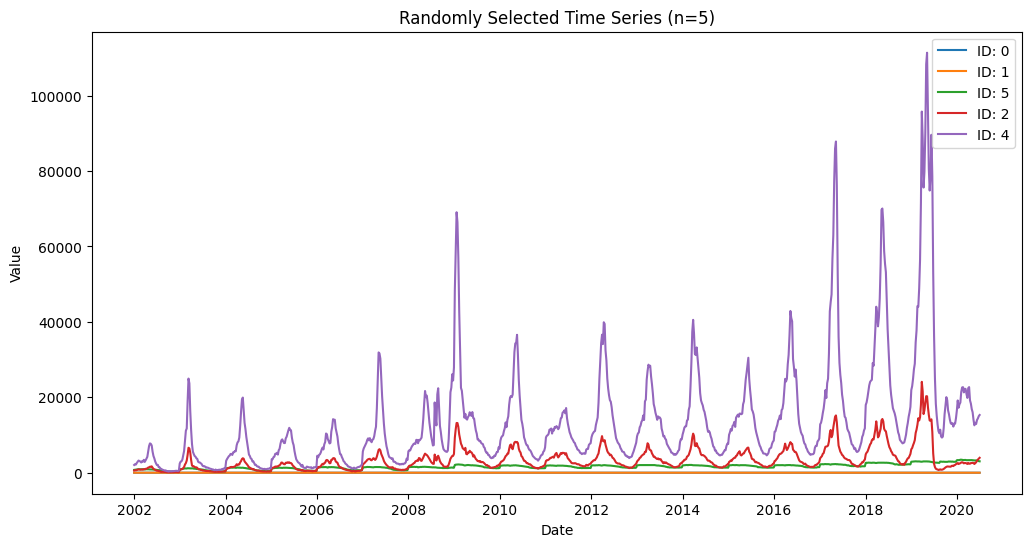

In [44]:
np.random.seed(42)
plot_random_time_series(df, n=5)

### Plot critical difference diagram for preprocessing methods

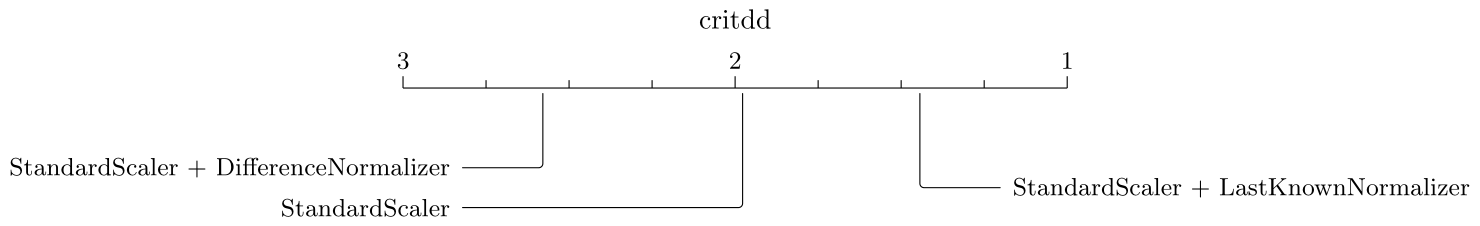

In [45]:
%tikz "$critical_difference_code" -p "$preamble" -r -d=200

- __The LastKnownNormalizer significantly outperforms default preprocessing strategies__

### Compare hyperparameters 

In [46]:
display(hparams_comparison_table)

(NN, Rank)  (NN, Median MAE)  \
Hyperparam    Value                                              
datetime      False                 1.381944          1.008674   
              True                  1.618056          1.132314   
id            False                 1.726190          1.078031   
              True                  1.273810          1.002403   
mode          global                1.547619          1.005592   
              multivariate CI       2.261905          1.121740   
              multivariate CM       2.190476          1.131925   
strategy_time FlatWideMIMO          3.937500          1.307954   
              MIMO                  1.750000          1.027963   
              Recursive (MH = 1)    2.416667          1.031449   
              Recursive (MH = 6)    1.895833          1.022826   

                                  (Boosting, Rank)  (Boosting, Median MAE)  \
Hyperparam    Value                                                          
datetime      False                       1.333333                1.604974   
              True                        1.666667                1.617397   
id            False                       1.571429                1.617397   
              True                        1.428571                1.589798   
mode          global                      1.095238                1.564849   
              multivariate CI                  NaN                     NaN   
              multivariate CM             1.904762                1.624808   
strategy_time FlatWideMIMO                2.888889                1.620753   
              MIMO                        2.444444                1.607232   
              Recursive (MH = 1)          2.777778                1.606648   
              Recursive (MH = 6)          1.888889                1.581624   

                                  (Overall, Rank)  (Overall, Median MAE)  
Hyperparam    Value                                                       
datetime      False                      1.374269               1.044819  
              True                       1.625731               1.178527  
id            False                      1.695238               1.131925  
              True                       1.304762               1.061101  
mode          global                     1.547619               1.073479  
              multivariate CI            2.261905               1.121740  
              multivariate CM            2.190476               1.212908  
strategy_time FlatWideMIMO               3.771930               1.354324  
              MIMO                       1.859649               1.062110  
              Recursive (MH = 1)         2.473684               1.076293  
              Recursive (MH = 6)         1.894737               1.054066

- __The id features improved model accuracy for both neural networks and GBDT.__
- __The date features led to worse performance for both neural networks and GBDT.__
- __The Global approach outperformed the multivariate one, achieving the lowest rank and median MAE across all models.__
- __The MIMO strategy ranked best for neural networks, while Rec-MIMO (MH = 6) achieved the lowest median MAE. Rec-MIMO (MH = 6) is the best strategy for GBDT in rankings and median MAE.__

### Compare models and strategies

In [47]:
display(top10_table)

,Model (test),Strategy (test),MAE (test),Model (val),Strategy (val),MAE (val)
rank,,,,,,
1,GPT4TS,Recursive (MH = 6),0.780371,GPT4TS,MIMO,0.271333
2,GPT4TS,Recursive (MH = 1),0.782212,GPT4TS,Recursive (MH = 6),0.283282
3,PyBoost,FlatWideMIMO,0.792144,GPT4TS,Recursive (MH = 1),0.293814
4,GPT4TS,MIMO,0.792593,PatchTST,MIMO,0.300529
5,PatchTST,Recursive (MH = 6),0.862964,PatchTST,Recursive (MH = 6),0.304980
6,PatchTST,MIMO,0.876885,DLinear,Recursive (MH = 6),0.316898
7,PatchTST,Recursive (MH = 1),0.894949,PatchTST,Recursive (MH = 1),0.317978
8,DLinear,Recursive (MH = 6),0.919302,DLinear,MIMO,0.320469
9,DLinear,MIMO,0.921975,PyBoost,FlatWideMIMO,0.323934


- __GPT4TS outperformed all other models.__
- __The Rec-MIMO strategy with MH = 6 achieved the best overall test MAE. However, on the validation set, the highest-ranked strategy was MIMO.__
- __The FlatWideMIMO combined with boosting models also ranked among the top strategies.__

## Dataset 2: demand_forecasting_kernels

In [13]:
df = pd.read_csv("../../../datasets/global/demand_forecasting_kernels.csv")
df["date"] = pd.to_datetime(df["date"])
df.head()

critical_difference_code = get_cd_diagram_for_dataset(current_df, dataset="demand_forecasting_kernels")
hparams_comparison_table = get_hparams_comparison_table_for_dataset(current_df, dataset="demand_forecasting_kernels")
top10_table = get_top10_test_val_table_for_dataset(current_df, dataset="demand_forecasting_kernels")

### Plot random 5 time series

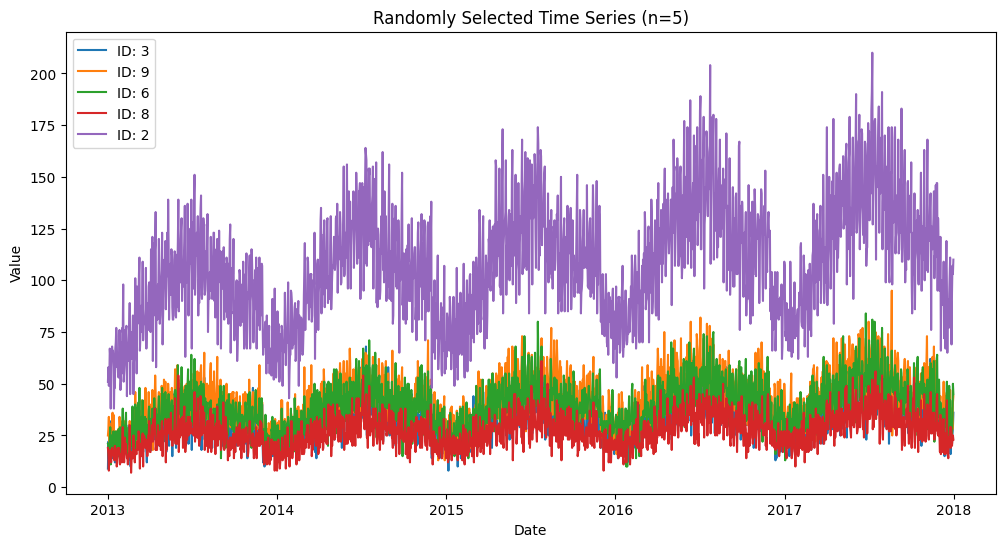

In [14]:
np.random.seed(43)
plot_random_time_series(df, n=5)

### Plot critical difference diagram for preprocessing methods

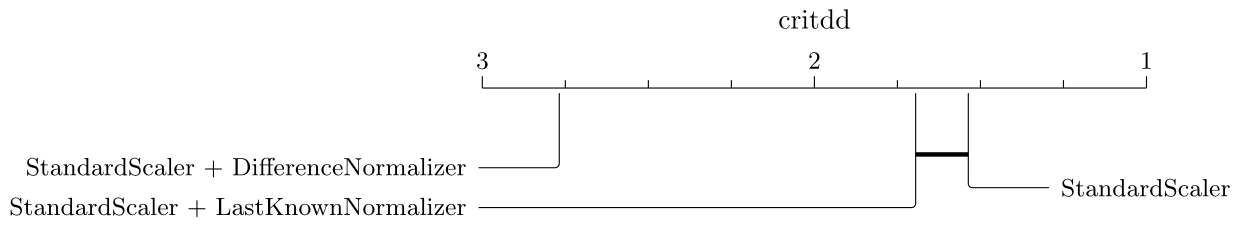

In [15]:
%tikz "$critical_difference_code" -p "$preamble" -r -d=200

- __There is no significant difference between LastKnownNormalizer and default preprocessing strategy. Only DifferenceNormalizer is significantly worse.__

### Compare hyperparameters 

In [16]:
display(hparams_comparison_table)

(NN, Rank)  (NN, Median MAE)  \
Hyperparam    Value                                              
datetime      False                 1.921348          0.593061   
              True                  1.078652          0.555621   
id            False                 1.340909          0.595927   
              True                  1.659091          0.543894   
mode          global                1.214286          0.542803   
              multivariate CI       2.535714          0.643744   
              multivariate CM       2.250000          0.624328   
strategy_time FlatWideMIMO          3.833333          0.909571   
              MIMO                  2.833333          0.586943   
              Recursive (MH = 1)    1.833333          0.588212   
              Recursive (MH = 6)    1.500000          0.581007   

                                  (Boosting, Rank)  (Boosting, Median MAE)  \
Hyperparam    Value                                                          
datetime      False                       1.388889                0.929137   
              True                        1.611111                0.935131   
id            False                       1.190476                0.929003   
              True                        1.809524                0.936761   
mode          global                      1.000000                0.933503   
              multivariate CI                  NaN                     NaN   
              multivariate CM             2.000000                0.937744   
strategy_time FlatWideMIMO                1.333333                0.697212   
              MIMO                        3.000000                0.936956   
              Recursive (MH = 1)          1.666667                0.933503   
              Recursive (MH = 6)          4.000000                0.929137   

                                  (Overall, Rank)  (Overall, Median MAE)  
Hyperparam    Value                                                       
datetime      False                      1.831776               0.605304  
              True                       1.168224               0.576450  
id            False                      1.292308               0.606572  
              True                       1.707692               0.586999  
mode          global                     1.214286               0.581462  
              multivariate CI            2.535714               0.643744  
              multivariate CM            2.250000               0.628857  
strategy_time FlatWideMIMO               2.583333               0.770538  
              MIMO                       2.916667               0.592405  
              Recursive (MH = 1)         1.750000               0.593189  
              Recursive (MH = 6)         2.750000               0.589076

- __The id features worsen model accuracy for both neural networks and GBDT in terms of ranking but have slightly better median MAE in cases of neural networks.__
- __The date features led to worse performance for GBDT, while for neural networks, they improved the ranking and median MAE.__
- __The Global approach outperformed the multivariate one, but the CM is better then CI for neural networks.__
- __The Rec-MIMO (MH = 6) strategy ranked best for neural networks and achieved the lowest median MAE. Interestingly, the FlatWideMIMO strategy was the best for GBDT in terms of ranking and median MAE.__

### Compare models and strategies

In [17]:
display(top10_table)

,Model (test),Strategy (test),MAE (test),Model (val),Strategy (val),MAE (val)
rank,,,,,,
1,PatchTST,Recursive (MH = 1),0.485504,PatchTST,Recursive (MH = 1),0.483100
2,GPT4TS,Recursive (MH = 6),0.488392,GPT4TS,Recursive (MH = 6),0.483191
3,GPT4TS,MIMO,0.489168,GPT4TS,MIMO,0.484633
4,PatchTST,Recursive (MH = 6),0.491081,PatchTST,Recursive (MH = 6),0.485706
5,PatchTST,MIMO,0.510108,PyBoost,FlatWideMIMO,0.507980
6,PyBoost,FlatWideMIMO,0.535954,PatchTST,MIMO,0.520824
7,DLinear,Recursive (MH = 1),0.537184,DLinear,MIMO,0.547979
8,DLinear,MIMO,0.537666,DLinear,Recursive (MH = 6),0.549334
9,DLinear,Recursive (MH = 6),0.538015,DLinear,Recursive (MH = 1),0.552395


- __PatchTST outperformed all other models.__
- __The Rec and Rec-MIMO strategy with MH = 6 achieved the best overall test MAE and validation MAE, too.__
- __The FlatWideMIMO combined with boosting models also ranked among the top strategies.__

## Dataset 3: fred_md

In [18]:
df = pd.read_csv("../../../datasets/global/fred_md.csv")
df["date"] = pd.to_datetime(df["date"])
df.head()

critical_difference_code = get_cd_diagram_for_dataset(current_df, dataset="fred_md")
hparams_comparison_table = get_hparams_comparison_table_for_dataset(current_df, dataset="fred_md")
top10_table = get_top10_test_val_table_for_dataset(current_df, dataset="fred_md")

### Plot random 5 time series

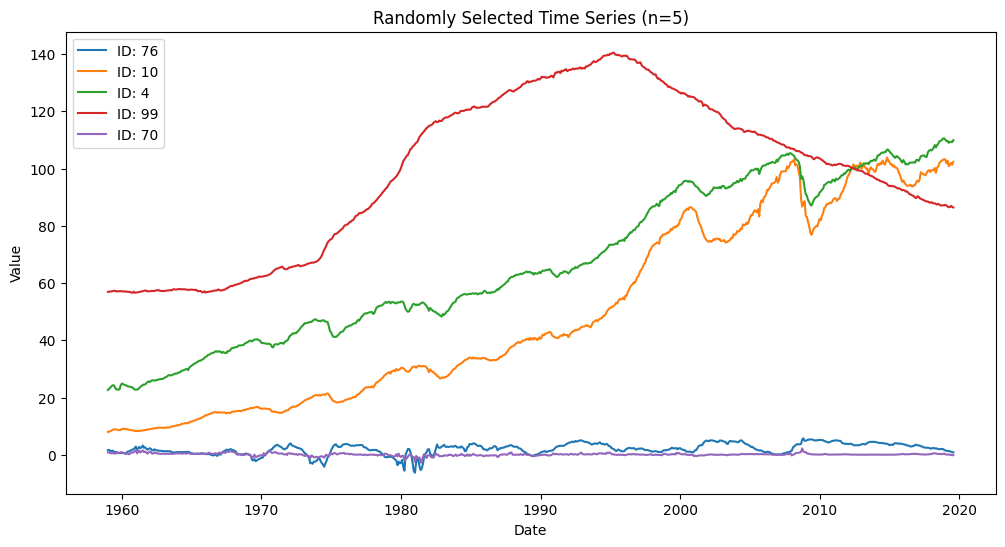

In [19]:
np.random.seed(42)
plot_random_time_series(df, n=5)

### Plot critical difference diagram for preprocessing methods

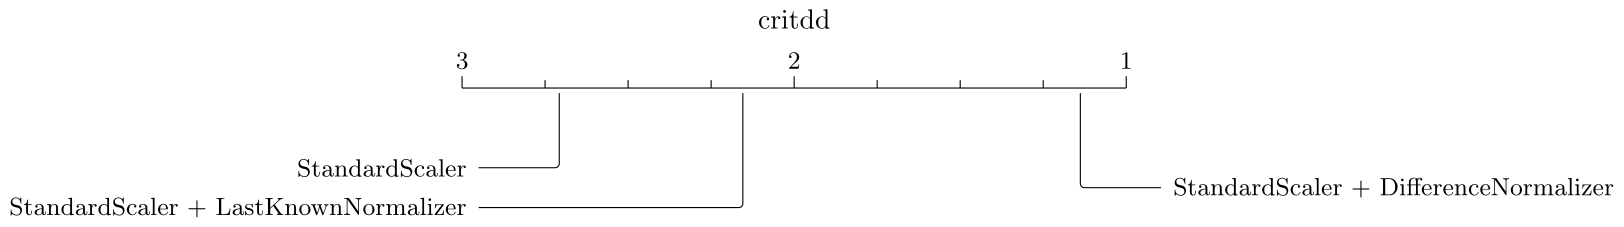

In [20]:
%tikz "$critical_difference_code" -p "$preamble" -r -d=200

- __Interestingly, the DifferenceNormalizer is significantly better than LastKnownNormalizer and default preprocessing strategy.__
- __The LastKnownNormalizer is still significantly better than default preprocessing strategy.__

### Compare hyperparameters 

In [21]:
display(hparams_comparison_table)

(NN, Rank)  (NN, Median MAE)  \
Hyperparam    Value                                              
datetime      False                 1.511111          1.113368   
              True                  1.488889          1.093973   
id            False                 1.443038          1.261253   
              True                  1.556962          1.055472   
mode          global                1.603448          1.050418   
              multivariate CI       1.672414          1.356887   
              multivariate CM       2.724138          2.112356   
strategy_time FlatWideMIMO          3.236842          1.351471   
              MIMO                  2.368421          1.077050   
              Recursive (MH = 1)    2.394737          1.125695   
              Recursive (MH = 6)    2.000000          1.075497   

                                  (Boosting, Rank)  (Boosting, Median MAE)  \
Hyperparam    Value                                                          
datetime      False                       1.481481                0.836091   
              True                        1.518519                0.836293   
id            False                       1.380952                0.837225   
              True                        1.619048                0.832215   
mode          global                      1.142857                0.832248   
              multivariate CI                  NaN                     NaN   
              multivariate CM             1.857143                0.845302   
strategy_time FlatWideMIMO                2.000000                0.836314   
              MIMO                        2.666667                0.835507   
              Recursive (MH = 1)          3.222222                0.837225   
              Recursive (MH = 6)          2.111111                0.836091   

                                  (Overall, Rank)  (Overall, Median MAE)  
Hyperparam    Value                                                       
datetime      False                      1.506173               1.057361  
              True                       1.493827               1.081464  
id            False                      1.430000               1.155574  
              True                       1.570000               1.051223  
mode          global                     1.603448               1.034933  
              multivariate CI            1.672414               1.356887  
              multivariate CM            2.724138               2.082632  
strategy_time FlatWideMIMO               3.000000               1.259366  
              MIMO                       2.425532               1.057200  
              Recursive (MH = 1)         2.553191               1.090583  
              Recursive (MH = 6)         2.021277               1.038945

- __The id features improved models' metrics in terms of median MAE for both neural networks and GBDT, but they worsened the ranking.__
- __The date features have controversial impact on models' metrics: they improved the ranking and median MAE for neural networks, while for GBDT, they worsened the ranking and median MAE.__
- __The Global approach outperformed the multivariate one, achieving the lowest rank and median MAE across all models. CI is better than CM.__
- __The Rec-MIMO (MH = 6) strategy ranked best for neural networks and achieved the lowest median MAE. The FlatWideMIMO strategy was the best for GBDT in terms of ranking and MIMO has the lowest median MAE.__

### Compare models and strategies

In [22]:
display(top10_table)

,Model (test),Strategy (test),MAE (test),Model (val),Strategy (val),MAE (val)
rank,,,,,,
1,PyBoost,FlatWideMIMO,0.829482,DLinear,Recursive (MH = 1),0.232550
2,PyBoost,Recursive (MH = 6),0.831178,DLinear,Recursive (MH = 6),0.234800
3,PyBoost,Recursive (MH = 1),0.831339,DLinear,MIMO,0.242872
4,PyBoost,MIMO,0.831953,PatchTST,Recursive (MH = 1),0.251244
5,GPT4TS,FlatWideMIMO,0.840115,PyBoost,FlatWideMIMO,0.256777
6,CycleNet,FlatWideMIMO,0.846156,CycleNet,Recursive (MH = 1),0.258725
7,DLinear,Recursive (MH = 6),0.874565,PyBoost,Recursive (MH = 6),0.259062
8,DLinear,MIMO,0.876150,PyBoost,MIMO,0.260411
9,DLinear,Recursive (MH = 1),0.896066,PyBoost,Recursive (MH = 1),0.260752


- __The PyBoost with FlatWideMIMO and other strategies outperformed all other models. Nevertheless, on validation set DLinear achieved the best MAE.__

## Dataset 4: WTH

In [23]:
df = pd.read_csv("../../../datasets/global/WTH.csv")
df["date"] = pd.to_datetime(df["date"])
df.head()

critical_difference_code = get_cd_diagram_for_dataset(current_df, dataset="WTH")
hparams_comparison_table = get_hparams_comparison_table_for_dataset(current_df, dataset="WTH")
top10_table = get_top10_test_val_table_for_dataset(current_df, dataset="WTH")

### Plot random 5 time series

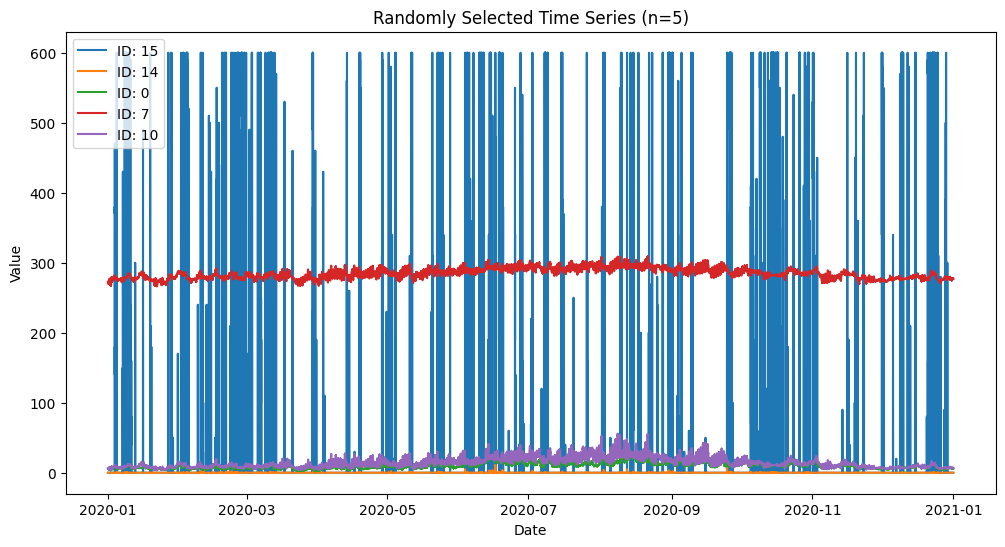

In [24]:
np.random.seed(44)
plot_random_time_series(df, n=5)

### Plot critical difference diagram for preprocessing methods

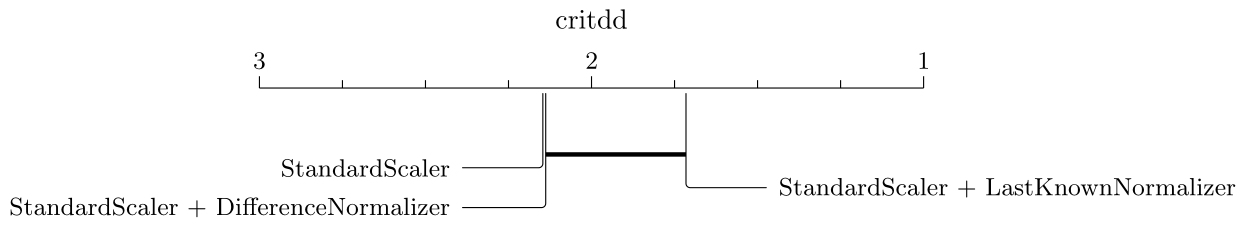

In [25]:
%tikz "$critical_difference_code" -p "$preamble" -r -d=200

- __There is no significant difference between preprocessing methods.__

### Compare hyperparameters 

In [26]:
display(hparams_comparison_table)

(NN, Rank)  (NN, Median MAE)  \
Hyperparam    Value                                              
datetime      False                 1.170543          0.155266   
              True                  1.829457          0.163378   
id            False                 1.434783          0.159265   
              True                  1.565217          0.160729   
mode          global                1.966667          0.159254   
              multivariate CI       2.166667          0.158375   
              multivariate CM       1.866667          0.161166   
strategy_time FlatWideMIMO          2.777778          0.166009   
              MIMO                  1.888889          0.155734   
              Recursive (MH = 1)    3.555556          0.167612   
              Recursive (MH = 6)    1.777778          0.157635   

                                  (Boosting, Rank)  (Boosting, Median MAE)  \
Hyperparam    Value                                                          
datetime      False                       1.333333                0.135377   
              True                        1.666667                0.135715   
id            False                       1.380952                0.136217   
              True                        1.619048                0.135201   
mode          global                      1.047619                0.135192   
              multivariate CI                  NaN                     NaN   
              multivariate CM             1.952381                0.136391   
strategy_time FlatWideMIMO                2.000000                0.136150   
              MIMO                        2.444444                0.136285   
              Recursive (MH = 1)          3.000000                0.135362   
              Recursive (MH = 6)          2.555556                0.135860   

                                  (Overall, Rank)  (Overall, Median MAE)  
Hyperparam    Value                                                       
datetime      False                      1.198718               0.154174  
              True                       1.801282               0.162110  
id            False                      1.422222               0.157863  
              True                       1.577778               0.157153  
mode          global                     1.966667               0.156015  
              multivariate CI            2.166667               0.158375  
              multivariate CM            1.866667               0.159841  
strategy_time FlatWideMIMO               2.388889               0.161667  
              MIMO                       2.166667               0.154610  
              Recursive (MH = 1)         3.277778               0.166071  
              Recursive (MH = 6)         2.166667               0.155410

- __The id features led to worse performance for both neural networks and GBDT.__
- __The date features have controversial impact on models' metrics: they worsen the ranking and median MAE for neural networks, while for GBDT (and overall), they worsened the ranking but improved the median MAE.__
- __Interestingly, the Multivariate CM approach outperformed the Global and CI approaches for neural networks, while the Global approach was the best for GBDT.__
- __The Rec-MIMO (MH = 6) strategy ranked best and the MIMO strategy achieved the lowest median MAE for neural networks. The FlatWideMIMO strategy ranked best for GBDT and the Recursive (MH = 1) achieved the lowest median MAE.__

### Compare models and strategies

In [27]:
display(top10_table)

,Model (test),Strategy (test),MAE (test),Model (val),Strategy (val),MAE (val)
rank,,,,,,
1,PyBoost,MIMO,0.131273,PyBoost,MIMO,0.184776
2,PyBoost,FlatWideMIMO,0.133003,PatchTST,MIMO,0.191516
3,PyBoost,Recursive (MH = 6),0.134297,CycleNet,MIMO,0.191622
4,PyBoost,Recursive (MH = 1),0.135083,GPT4TS,MIMO,0.194393
5,CycleNet,MIMO,0.137011,CycleNet,Recursive (MH = 6),0.195455
6,CycleNet,Recursive (MH = 6),0.137782,DLinear,MIMO,0.195506
7,PatchTST,MIMO,0.138726,DLinear,Recursive (MH = 6),0.197832
8,GPT4TS,MIMO,0.140127,DLinear,Recursive (MH = 1),0.200036
9,DLinear,MIMO,0.141839,PatchTST,Recursive (MH = 6),0.203787


- __The PyBoost with MIMO, FlatWideMIMO and other strategies outperformed all other models. Nevertheless, on validation set there are a lot of neural networks with top scores.__

## Dataset 5: nn5

In [28]:
df = pd.read_csv("../../../datasets/global/nn5.csv")
df["date"] = pd.to_datetime(df["date"])
df.head()

critical_difference_code = get_cd_diagram_for_dataset(current_df, dataset="nn5")
hparams_comparison_table = get_hparams_comparison_table_for_dataset(current_df, dataset="nn5")
top10_table = get_top10_test_val_table_for_dataset(current_df, dataset="nn5")

### Plot random 5 time series

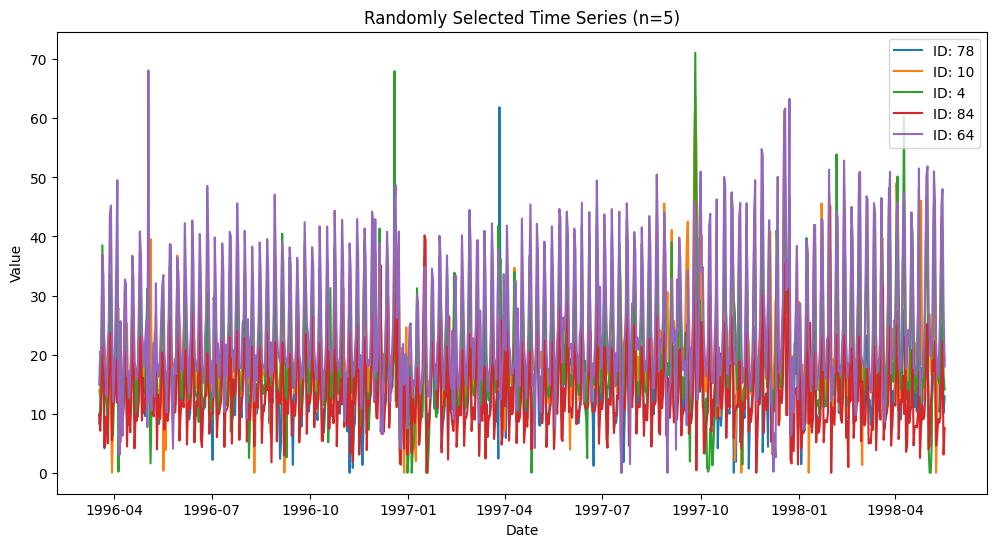

In [29]:
np.random.seed(42)
plot_random_time_series(df, n=5)

### Plot critical difference diagram for preprocessing methods

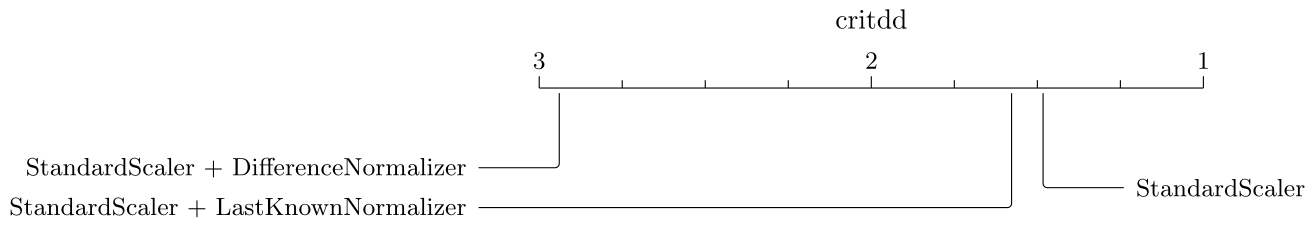

In [30]:
%tikz "$critical_difference_code" -p "$preamble" -r -d=200

- __Interestingly, the standard preprocessing strategy is significantly better than LastKnownNormalizer and DifferenceNormalizer.__
- __The LastKnownNormalizer is significantly better than DifferenceNormalizer.__

### Compare hyperparameters 

In [31]:
display(hparams_comparison_table)

(NN, Rank)  (NN, Median MAE)  \
Hyperparam    Value                                              
datetime      False                 1.755556          0.647940   
              True                  1.244444          0.647735   
id            False                 1.500000          0.678419   
              True                  1.500000          0.587492   
mode          global                1.000000          0.586845   
              multivariate CI       2.666667          0.888134   
              multivariate CM       2.333333          0.762083   
strategy_time FlatWideMIMO          3.714286          1.057068   
              MIMO                  2.095238          0.634274   
              Recursive (MH = 1)    1.857143          0.620030   
              Recursive (MH = 6)    2.333333          0.641834   

                                  (Boosting, Rank)  (Boosting, Median MAE)  \
Hyperparam    Value                                                          
datetime      False                       1.592593                1.108328   
              True                        1.407407                1.223846   
id            False                       1.222222                1.223846   
              True                        1.777778                1.220438   
mode          global                      1.000000                1.107697   
              multivariate CI                  NaN                     NaN   
              multivariate CM             2.000000                1.259828   
strategy_time FlatWideMIMO                1.666667                1.262696   
              MIMO                        3.000000                1.220438   
              Recursive (MH = 1)          3.333333                1.107061   
              Recursive (MH = 6)          2.000000                1.223846   

                                  (Overall, Rank)  (Overall, Median MAE)  
Hyperparam    Value                                                       
datetime      False                      1.728395               0.671530  
              True                       1.271605               0.708625  
id            False                      1.444444               0.737528  
              True                       1.555556               0.594109  
mode          global                     1.000000               0.594115  
              multivariate CI            2.666667               0.888134  
              multivariate CM            2.333333               0.813087  
strategy_time FlatWideMIMO               3.458333               1.085260  
              MIMO                       2.208333               0.674500  
              Recursive (MH = 1)         2.041667               0.665817  
              Recursive (MH = 6)         2.291667               0.670773

- __The id features improved models' metrics in terms of median MAE but worsened the ranking for both neural networks and GBDT.__
- __The date features have controversial impact on models' metrics: they improved the ranking and median MAE for neural networks, while for GBDT, they worsened the ranking but improved the median MAE.__
- __The Global approach outperformed the multivariate one, achieving the lowest rank and median MAE across all models. Interestingly, the CI approach is better than CM for neural networks.__
- __The Recursive (MH = 1) strategy ranked best for neural networks and achieved the lowest median MAE. The FlatWideMIMO strategy was the best for GBDT in terms of ranking and Recursive (MH = 1) has the lowest median MAE.__

### Compare models and strategies

In [32]:
display(top10_table)

,Model (test),Strategy (test),MAE (test),Model (val),Strategy (val),MAE (val)
rank,,,,,,
1,PatchTST,MIMO,0.485647,PyBoost,Recursive (MH = 1),0.495007
2,GPT4TS,MIMO,0.494770,DLinear,MIMO,0.497762
3,DLinear,MIMO,0.500803,DLinear,Recursive (MH = 6),0.500477
4,CycleNet,MIMO,0.511781,PatchTST,MIMO,0.501420
5,PatchTST,Recursive (MH = 6),0.522433,DLinear,Recursive (MH = 1),0.504359
6,DLinear,Recursive (MH = 6),0.529535,GPT4TS,Recursive (MH = 1),0.509160
7,GPT4TS,Recursive (MH = 6),0.531021,PatchTST,Recursive (MH = 6),0.510493
8,PatchTST,Recursive (MH = 1),0.531198,GPT4TS,Recursive (MH = 6),0.510879
9,CycleNet,Recursive (MH = 6),0.542012,GPT4TS,MIMO,0.511308


- __There is a lot of mismatches between validation and test sets.__
- __The MIMO and Rec-MIMO strategies achieved the best overall test MAE and validation MAE, too.__

## Aggregated results

In this section, we present the aggregated (by mean) results across all datasets for each model and strategy.

In [33]:
agg_df = current_df.groupby(
    ["model", "strategy_time", "datetime", "id", "mode", "transformer_name", "transformer_regime"]
).agg(
    {
        "mae_test": "mean",
        "rmse_test": "mean",
        "fit_time_test": "mean",
        "forecast_time_test": "mean",
        "mae_val": "mean",
        "rmse_val": "mean",
        "fit_time_val": "mean",
        "forecast_time_val": "mean",
    }
).reset_index()

critical_difference_code = get_cd_diagram_for_dataset(agg_df, dataset=False)
hparams_comparison_table = get_hparams_comparison_table_for_dataset(agg_df, dataset=False)
top10_table = get_top10_test_val_table_for_dataset(agg_df, dataset=False)

### Plot critical difference diagram for preprocessing methods

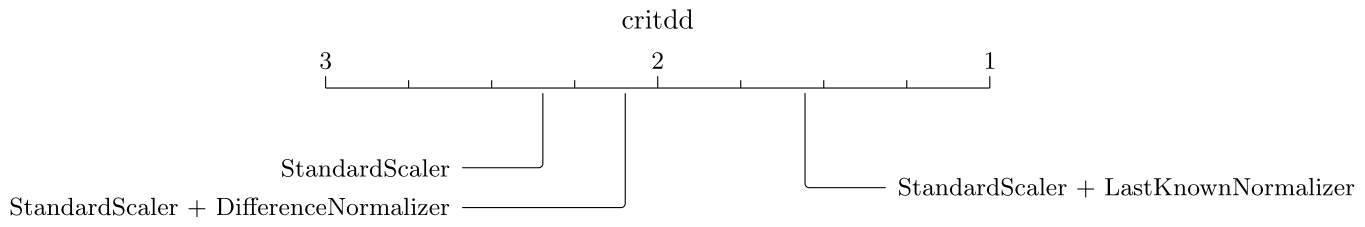

In [34]:
%tikz "$critical_difference_code" -p "$preamble" -r -d=200

- __Both LastKnownNormalizer and DifferenceNormalizer are significantly better than default preprocessing strategy.__
- __The LastKnownNormalizer in average is better than DifferenceNormalizer.__

### Compare hyperparameters 

In [35]:
display(hparams_comparison_table)

(NN, Rank)  (NN, Median MAE)  \
Hyperparam    Value                                              
datetime      False                 1.548611          0.747202   
              True                  1.451389          0.889819   
id            False                 1.642857          0.900342   
              True                  1.357143          0.688874   
mode          global                1.357143          0.696776   
              multivariate CI       2.011905          0.887193   
              multivariate CM       2.630952          0.971429   
strategy_time FlatWideMIMO          3.770833          1.237429   
              MIMO                  1.645833          0.743307   
              Recursive (MH = 1)    2.562500          0.804277   
              Recursive (MH = 6)    2.020833          0.763440   

                                  (Boosting, Rank)  (Boosting, Median MAE)  \
Hyperparam    Value                                                          
datetime      False                       1.259259                0.960951   
              True                        1.740741                0.963784   
id            False                       1.285714                0.999236   
              True                        1.714286                0.932680   
mode          global                      1.000000                0.933041   
              multivariate CI                  NaN                     NaN   
              multivariate CM             2.000000                1.115218   
strategy_time FlatWideMIMO                1.555556                0.964361   
              MIMO                        2.888889                0.966644   
              Recursive (MH = 1)          3.111111                0.978598   
              Recursive (MH = 6)          2.444444                0.961440   

                                  (Overall, Rank)  (Overall, Median MAE)  
Hyperparam    Value                                                       
datetime      False                      1.502924               0.800065  
              True                       1.497076               0.921884  
id            False                      1.571429               0.918923  
              True                       1.428571               0.725481  
mode          global                     1.357143               0.721807  
              multivariate CI            2.011905               0.887193  
              multivariate CM            2.630952               0.977439  
strategy_time FlatWideMIMO               3.421053               1.234239  
              MIMO                       1.842105               0.772740  
              Recursive (MH = 1)         2.649123               0.871930  
              Recursive (MH = 6)         2.087719               0.822332

- __The id features improved model accuracy for both neural networks, but worsened the ranking for GBDT.__
- __The date features led to worse performance for both neural networks and GBDT.__
- __The Global approach outperformed the multivariate one, achieving the lowest rank and median MAE across all models.__
- __The MIMO strategy ranked best for neural networks and achieved the lowest median MAE. The FlatWideMIMO strategy was the best for GBDT in terms of ranking and Rec-MIMO (FH = 6) has the lowest median MAE.__

### Compare models and strategies

In [36]:
display(top10_table)

,Model (test),Strategy (test),MAE (test),Model (val),Strategy (val),MAE (val)
rank,,,,,,
1,GPT4TS,MIMO,0.493110,GPT4TS,MIMO,0.242967
2,GPT4TS,Recursive (MH = 6),0.502903,GPT4TS,Recursive (MH = 6),0.269813
3,GPT4TS,Recursive (MH = 1),0.563229,PatchTST,Recursive (MH = 6),0.331282
4,PatchTST,Recursive (MH = 6),0.611775,GPT4TS,Recursive (MH = 1),0.339134
5,PatchTST,MIMO,0.613412,PatchTST,Recursive (MH = 1),0.347524
6,PatchTST,Recursive (MH = 1),0.632810,CycleNet,MIMO,0.351955
7,CycleNet,Recursive (MH = 1),0.646101,CycleNet,Recursive (MH = 6),0.355052
8,CycleNet,MIMO,0.648690,CycleNet,Recursive (MH = 1),0.359618
9,CycleNet,Recursive (MH = 6),0.649448,PatchTST,MIMO,0.369891


- __GPT4TS outperformed all other models.__
- __The MIMO and Rec-MIMO (FH = 6) achieved the best overall test MAE.__